ABOUT:
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. A machine learning model is built, that would predict which Tweets are about real disasters and which ones aren’t.

In [1]:
# IMPORTING LIBRARIES AND DATA
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for formattting and handling text 
import string 
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


#Library for Splitting Dataset
from sklearn.model_selection import train_test_split


#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

from tensorflow.keras.utils import plot_model

#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

TEXT ANALYSIS

In [4]:
train_data.head().style.background_gradient(cmap='coolwarm')

,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
print("Number of rows is = ", train_data.shape[0], " \nNumber of columns is = " , train_data.shape[1]) 

Number of rows is =  7613  
Number of columns is =  5


In [6]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


DATA ANALYSIS AND VISUALIZATION

In [7]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

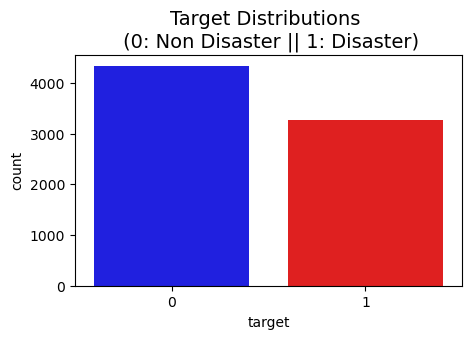

In [8]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train_data, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

In [9]:
# KEYWORDS
train_data["keyword"].nunique()

221

Text(0.5, 0, 'Count of Keywords')

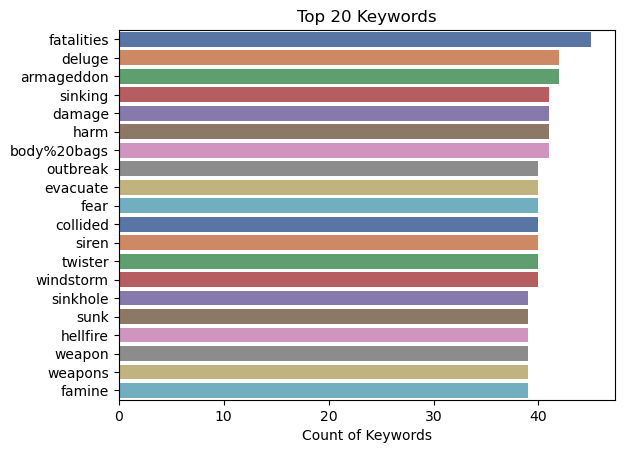

In [10]:
# TOP 20 KEYWORDS
chains=train_data['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

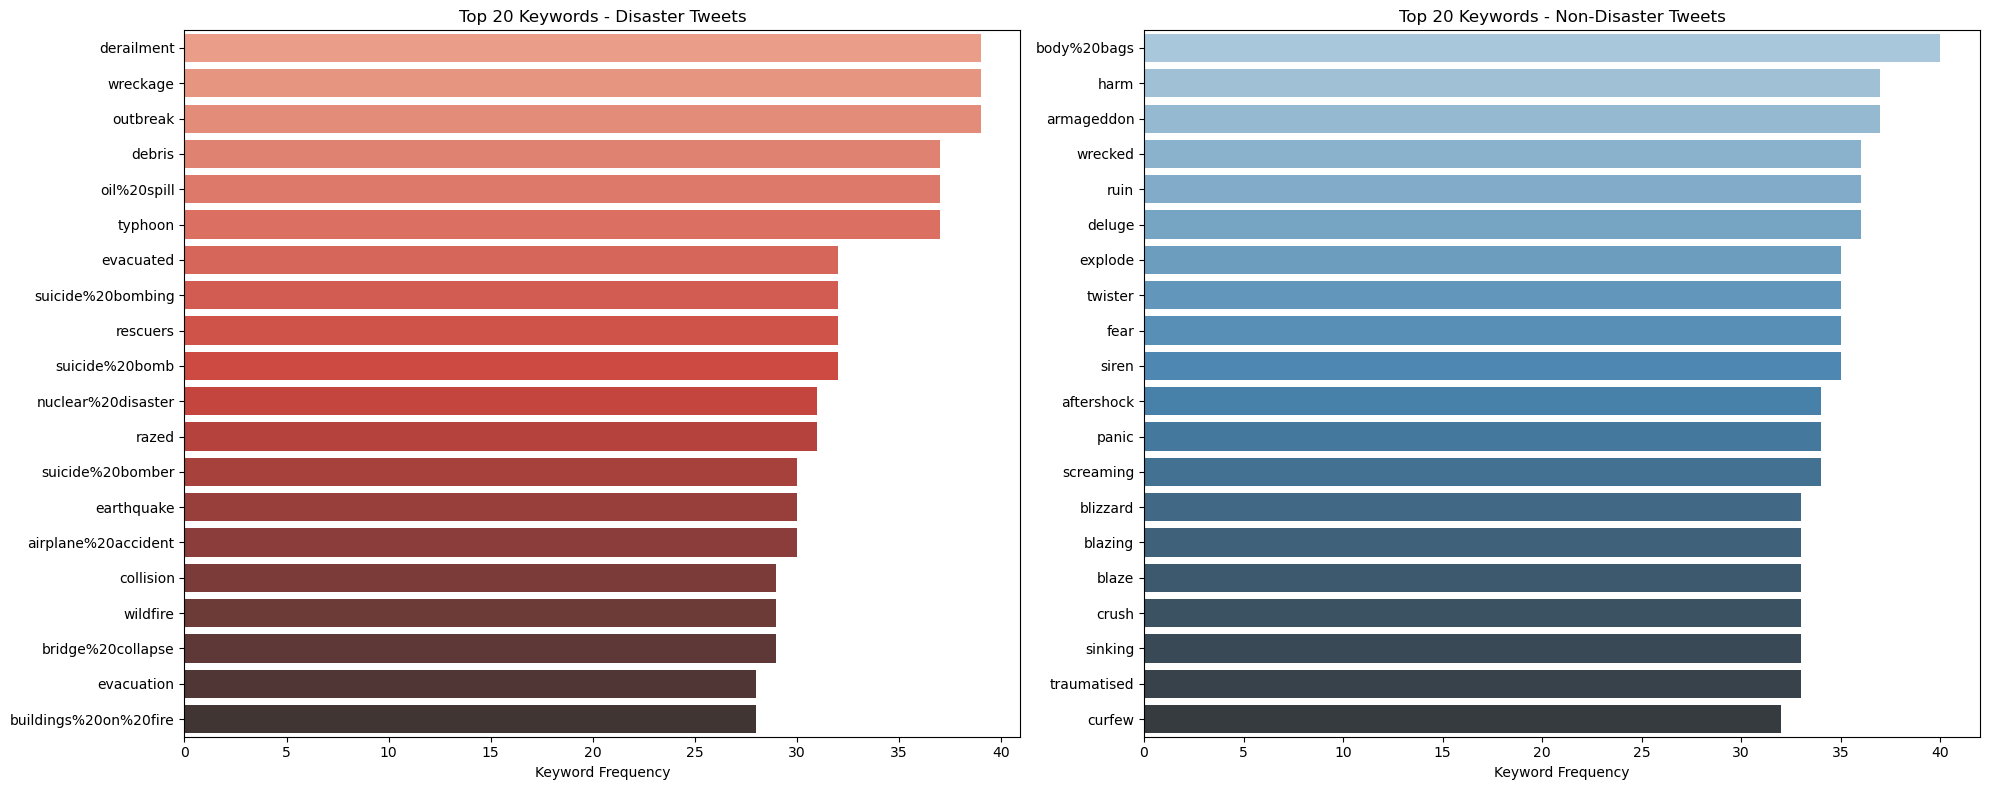

In [11]:
# TOP 20 DISASTER AND NON-DISASTER KEYWORDS
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

In [12]:
# HIGHEST AND LOWEST USAGE KEYWORD
top_disaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values(ascending = False).head(20)
top_nondisaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values().head(20)

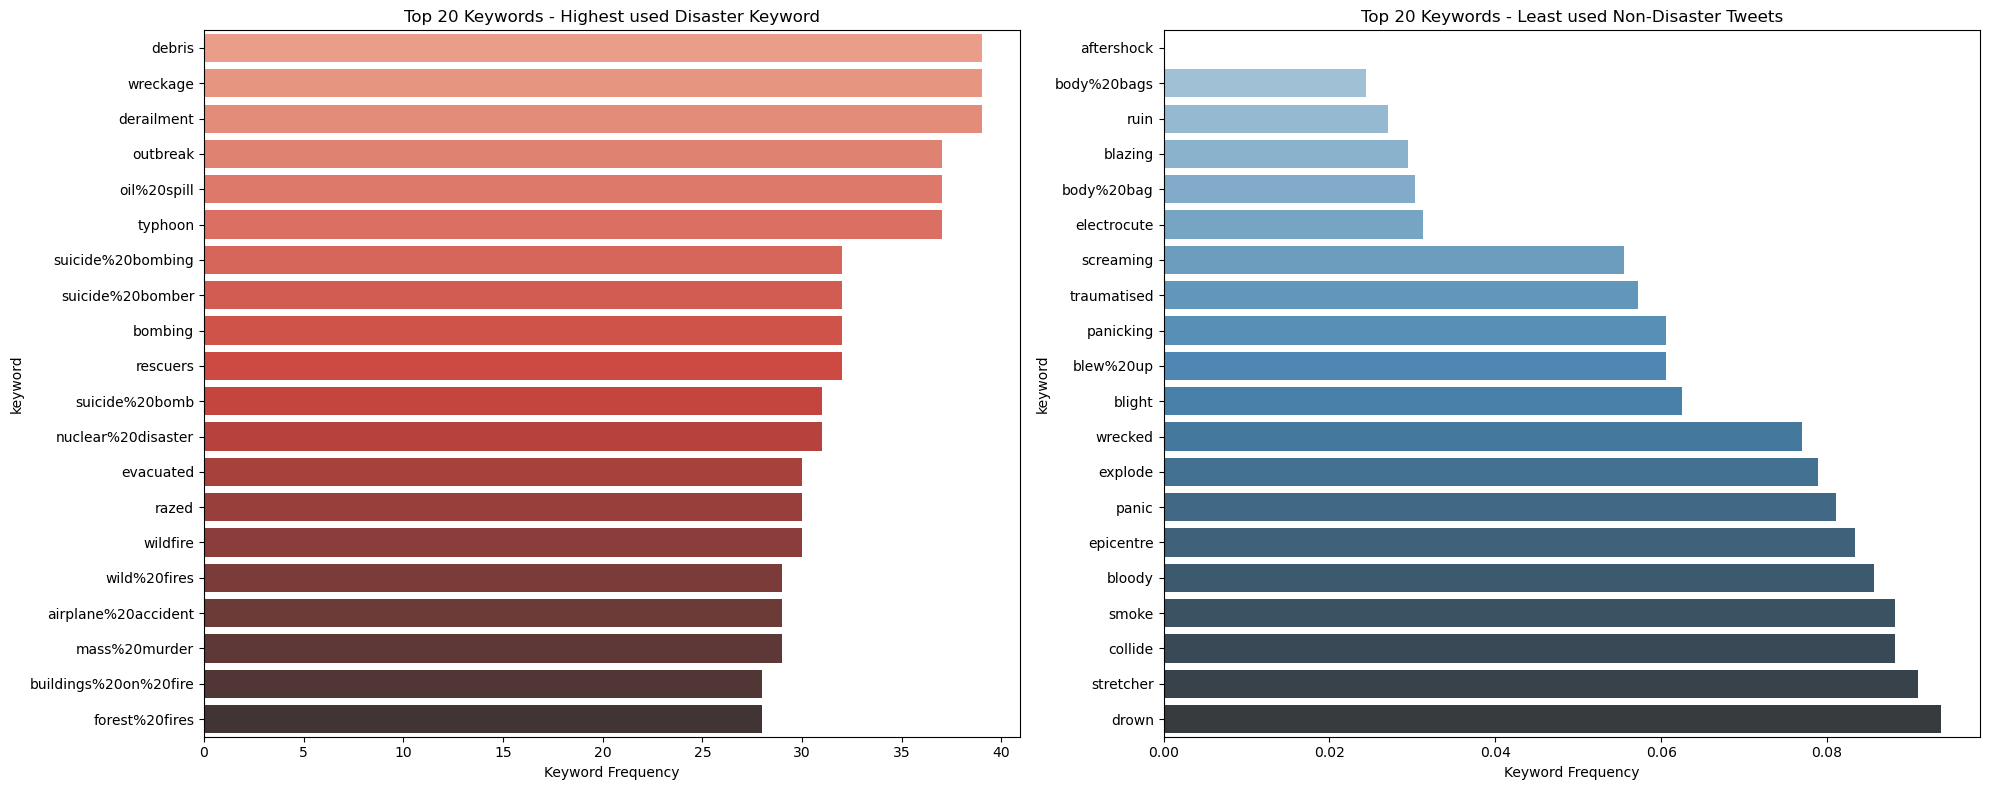

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

sns.barplot(y=top_disaster_keyword[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Highest used Disaster Keyword")
ax[0].set_xlabel("Keyword Frequency")


sns.barplot(y=top_nondisaster_keyword[0:20].index, x=top_nondisaster_keyword[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Least used Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

In [14]:
# TWEET LOCATION
locations = train_data["location"].value_counts()

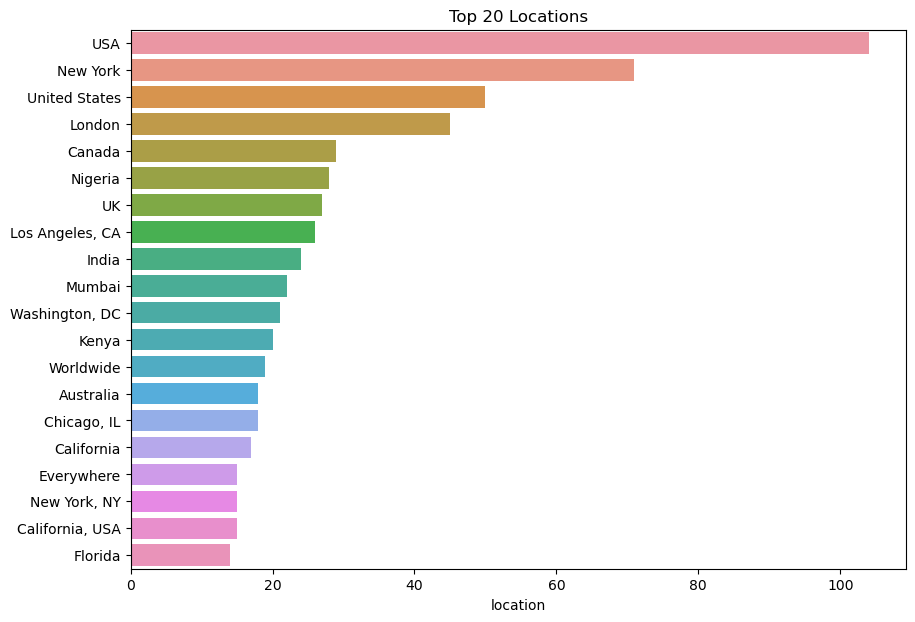

In [15]:
plt.figure(figsize=(10,7))


sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')

plt.title("Top 20 Locations")
plt.show()

In [16]:
print(len(train_data['text']))

7613


In [17]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [18]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [19]:
train_data[train_data['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

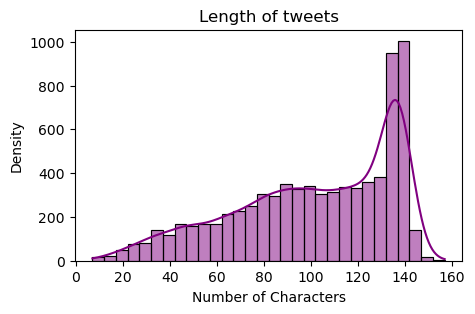

In [20]:
# TWEET LENGTH
plt.figure(figsize=(5,3))
sns.histplot(train_data["length"], kde=True,color='purple',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

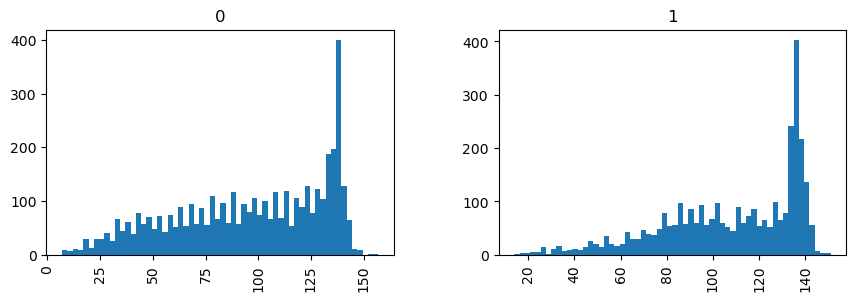

In [21]:
# TWEETS WRT TARGET
train_data.hist(column='length', by = 'target',bins =60, figsize= (10,3))

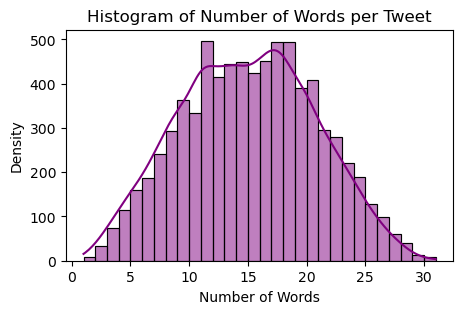

In [22]:
# WORD COUNT IN TWEET 
def count_words(x):
    return len(x.split())

train_data["num_words"] = train_data["text"].apply(count_words)

plt.figure(figsize=(5,3))
sns.histplot(train_data["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

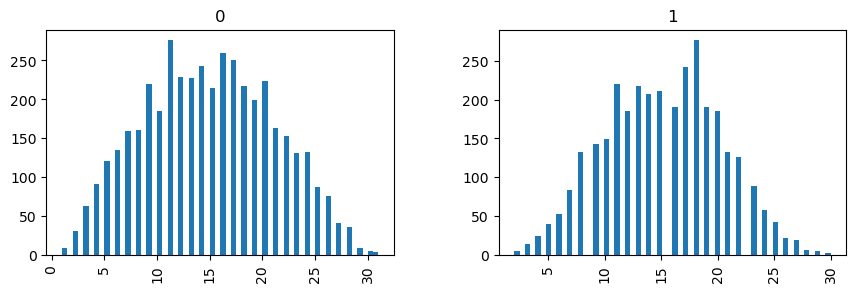

In [23]:
# WORDS IN TWEET WRT TARGET
train_data.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

TEXT-PREPROCESSING

In [24]:
# REMOVING PUNCTUATIONS
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
def toclean_text(text):

    
    clean_text = [char for char in text if char not in string.punctuation]
   
    clean_text = ''.join(clean_text)
    
        
    return clean_text

In [26]:
train_data['clean_text'] = train_data['text'].apply(toclean_text)

In [27]:
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,Just got sent this photo from Ruby Alaska as s...


In [28]:
# REMOVING STOPWORDS
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
def toremove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return remove_stopword

In [30]:
train_data['clean_text'] = train_data['clean_text'].apply(toremove_stopword)

In [31]:
train_data.head()

,id,keyword,location,text,target,length,num_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


In [32]:
# TOKENIZING
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)

In [33]:
X.shape

(7613, 20)

In [34]:
X[0] #In X[0] out 7 cleaned word only 5 belong to top 3000 words.

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  716,  152,   54, 1454,   13], dtype=int32)

In [35]:
tokenizer.sequences_to_texts([[ 713,  154,   56, 1434,   14]])

['11yearold flooding life antioch 2']

MODEL CREATION USING LSTM

In [36]:
y = train_data['target']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

In [38]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [39]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 6s 18ms/step - loss: 0.5466 - accuracy: 0.7238 - val_loss: 0.4371 - val_accuracy: 0.8109
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3767 - accuracy: 0.8404 - val_loss: 0.4426 - val_accuracy: 0.8109
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3194 - accuracy: 0.8693 - val_loss: 0.4698 - val_accuracy: 0.8037
Epoch 4/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2863 - accuracy: 0.8808 - val_loss: 0.4990 - val_accuracy: 0.7886
Epoch 5/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2581 - accuracy: 0.8924 - val_loss: 0.5491 - val_accuracy: 0.7840
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2251 - accuracy: 0.9048 - val_loss: 0.6294 - val_accuracy: 0.7748
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 0.2106 - accuracy: 0.9110 - val_loss: 0.6940 - val_accuracy: 0.7669

In [41]:
y_pred = model.predict(X_test).round()

48/48 [==============================] - 0s 4ms/step


In [42]:
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

EVALUATION

In [43]:
# ACCURACY
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

191/191 [==============================] - 1s 4ms/step


95

In [44]:
# PRECISION, RECALL 
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7596848325673013
Recall  is    :  0.7134146341463414
Precision  is :  0.7244582043343654


In [45]:
# CONFUSION MATRIX
conm = confusion_matrix(y_test,y_pred)
conm

array([[689, 178],
       [188, 468]])

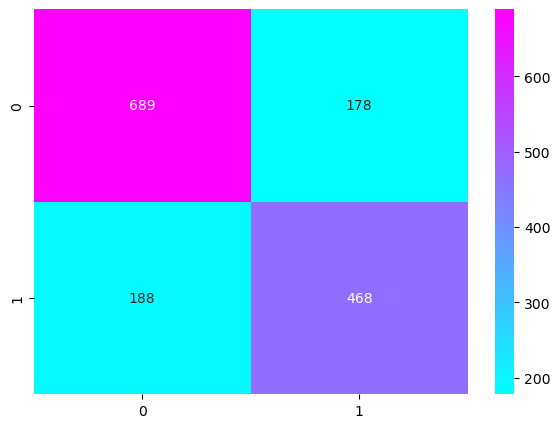

In [46]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

SUBMISSION

In [47]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [48]:
test_data.head().style.background_gradient(cmap='coolwarm')

,id,keyword,location,text
0,0,nan,nan,Just happened a terrible car crash
1,2,nan,nan,"Heard about #earthquake is different cities, stay safe everyone."
2,3,nan,nan,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,nan,nan,Apocalypse lighting. #Spokane #wildfires
4,11,nan,nan,Typhoon Soudelor kills 28 in China and Taiwan


In [49]:
test_data['clean_text'] = test_data['text'].apply(toclean_text)

In [50]:
test_data['clean_text'].head()

0                   Just happened a terrible car crash
1    Heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                Apocalypse lighting Spokane wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: clean_text, dtype: object

In [51]:
# CREATING NEW MODEL FOR SUBMISSION
# ADDING 2 LAYERS 
# max_features = 5000
# l =50
# learning_rate=2e-3
# lstm_out = 100

In [52]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X, maxlen =l)

In [53]:
tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [54]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [55]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [56]:
model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 27s 115ms/step - loss: 0.5200 - accuracy: 0.7425 - val_loss: 0.4771 - val_accuracy: 0.7741
Epoch 2/10
191/191 [==============================] - 22s 113ms/step - loss: 0.3531 - accuracy: 0.8553 - val_loss: 0.4806 - val_accuracy: 0.7859
Epoch 3/10
191/191 [==============================] - 21s 111ms/step - loss: 0.2827 - accuracy: 0.8878 - val_loss: 0.5717 - val_accuracy: 0.7597
Epoch 4/10
191/191 [==============================] - 21s 112ms/step - loss: 0.2324 - accuracy: 0.9089 - val_loss: 0.6012 - val_accuracy: 0.7564


In [57]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

102/102 [==============================] - 2s 18ms/step


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.385228
std,3146.427221,0.486724
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


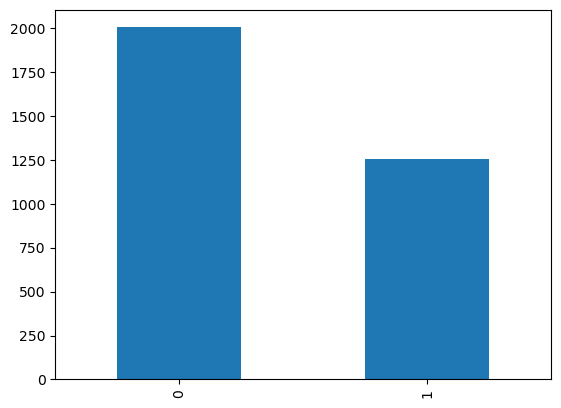

In [58]:
submission.target.value_counts().plot.bar();